<a href="https://colab.research.google.com/github/faizankshaikh/CompBattle/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q gymnasium pettingzoo tianshou
# !git clone https://github.com/faizankshaikh/CompBattle.git
%cd CompBattle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 22.0 MB/s eta 0:00:00
Cloning into 'CompBattle'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 50 (delta 13), reused 19 (delta 5), pack-reused 0
Unpacking objects: 100% (50/50), 418.22 KiB | 1.51 MiB/s, done.
/content/CompBattle


In [2]:
%load_ext tensorboard

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from comp.envs.comp_v0 import Comp

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [3]:
env = Comp()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Score [player1, player2]:[-240 -263]


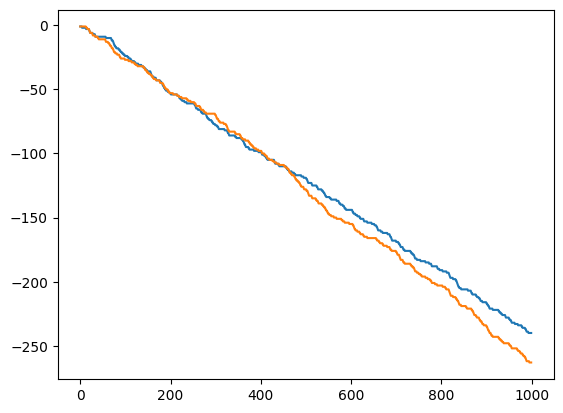

In [4]:
# both always cooperate
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.show()

Score [player1, player2]:[-664 -668]


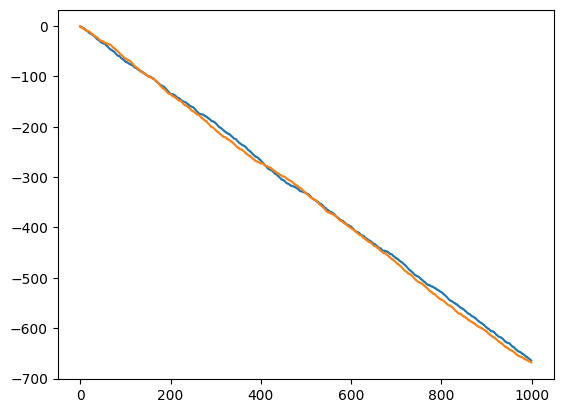

In [5]:
# both always defect
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.show()

Score [player1, player2]:[-104 -684]


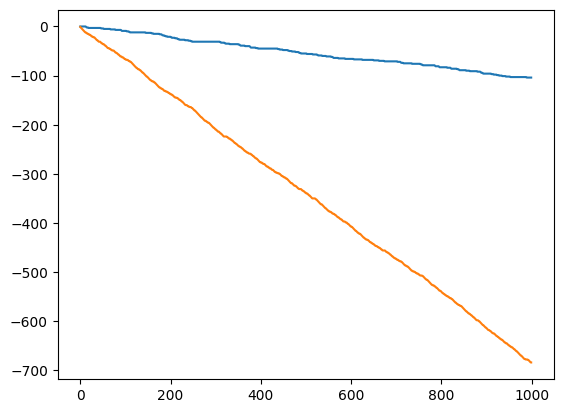

In [6]:
# player1 defects, player2 cooperates
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.show()

Score [player1, player2]:[-714  -92]


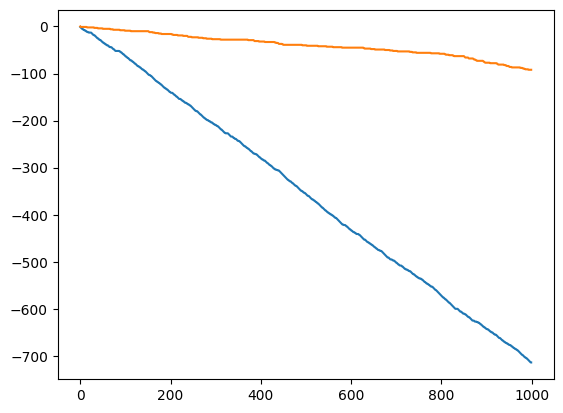

In [7]:
# player1 cooperates, player2 defects
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.show()

In [53]:
## agent that always forages
class AlwaysForage(BasePolicy):
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always attacks
class AlwaysAttack(BasePolicy):
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to forage
class HailMary(BasePolicy):
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 1] <= 1:
                logits[i, 0] = 1
            else:
                logits[i, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [59]:
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env():
    env = Comp()
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

env = Comp()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent():
    vec_env = _get_env()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    return DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=320,
    )

agent_learn1 = _get_agent()
agent_learn2 = _get_agent()

policy = MultiAgentPolicyManager([HailMary(), agent_learn1],  _get_env())

train_envs = DummyVectorEnv([_get_env for _ in range(5)])
test_envs = DummyVectorEnv([_get_env for _ in range(2)])

# Step 4: Collector setup
train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)
test_collector = Collector(policy, test_envs, exploration_noise=True)

train_collector.collect(n_step=50)

def save_best_fn(policy):
    model_save_path = os.path.join("log", "comp", "dqn", "policy.pth")
    os.makedirs(os.path.join("log", "comp", "dqn"), exist_ok=True)
    torch.save(policy.policies[agents[1]].state_dict(), model_save_path)

def stop_fn(mean_rewards):
    return mean_rewards >= 0.6

def train_fn(epoch, env_step):
    policy.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    policy.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

log_path = os.path.join("log", "comp", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [64]:
# Step 5: Run trainer
result = offpolicy_trainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=20,
    step_per_epoch=1000,
    step_per_collect=50,
    episode_per_test=100,
    batch_size=64,
    train_fn=train_fn,
    test_fn=test_fn,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn,
    update_per_step=0.1,
    test_in_train=False,
    reward_metric=reward_metric,
    logger=logger
)
result

Epoch #1: 1001it [00:00, 1182.68it/s, env_step=1000, len=6, n/ep=5, n/st=50, player2/loss=0.133, rew=-0.40]                          


Epoch #1: test_reward: -0.370000 ± 0.482804, best_reward: -0.280000 ± 0.448999 in #0


Epoch #2: 1001it [00:00, 1173.86it/s, env_step=2000, len=6, n/ep=10, n/st=50, player2/loss=0.075, rew=-0.60]                          


Epoch #2: test_reward: -0.420000 ± 0.493559, best_reward: -0.280000 ± 0.448999 in #0


Epoch #3: 1001it [00:00, 1155.61it/s, env_step=3000, len=6, n/ep=10, n/st=50, player2/loss=0.088, rew=-0.10]                          


Epoch #3: test_reward: -0.340000 ± 0.473709, best_reward: -0.280000 ± 0.448999 in #0


Epoch #4: 1001it [00:00, 1179.39it/s, env_step=4000, len=6, n/ep=5, n/st=50, player2/loss=0.074, rew=-0.20]                          


Epoch #4: test_reward: -0.370000 ± 0.482804, best_reward: -0.280000 ± 0.448999 in #0


Epoch #5: 1001it [00:00, 1201.60it/s, env_step=5000, len=6, n/ep=10, n/st=50, player2/loss=0.057, rew=-0.50]                          


Epoch #5: test_reward: -0.300000 ± 0.458258, best_reward: -0.280000 ± 0.448999 in #0


Epoch #6: 1001it [00:01, 863.10it/s, env_step=6000, len=6, n/ep=10, n/st=50, player2/loss=0.100, rew=-0.30]                          


Epoch #6: test_reward: -0.230000 ± 0.420833, best_reward: -0.230000 ± 0.420833 in #6


Epoch #7: 1001it [00:01, 834.93it/s, env_step=7000, len=6, n/ep=5, n/st=50, player2/loss=0.133, rew=0.00]                          


Epoch #7: test_reward: -0.280000 ± 0.448999, best_reward: -0.230000 ± 0.420833 in #6


Epoch #8: 1001it [00:00, 1202.23it/s, env_step=8000, len=6, n/ep=10, n/st=50, player2/loss=0.106, rew=-0.30]                          


Epoch #8: test_reward: -0.300000 ± 0.458258, best_reward: -0.230000 ± 0.420833 in #6


Epoch #9: 1001it [00:00, 1166.54it/s, env_step=9000, len=6, n/ep=10, n/st=50, player2/loss=0.142, rew=-0.10]                          


Epoch #9: test_reward: -0.350000 ± 0.476970, best_reward: -0.230000 ± 0.420833 in #6


Epoch #10: 1001it [00:00, 1147.87it/s, env_step=10000, len=6, n/ep=5, n/st=50, player2/loss=0.216, rew=-0.40]                          


Epoch #10: test_reward: -0.290000 ± 0.453762, best_reward: -0.230000 ± 0.420833 in #6


Epoch #11: 1001it [00:00, 1145.51it/s, env_step=11000, len=6, n/ep=10, n/st=50, player2/loss=0.209, rew=-0.30]                          


Epoch #11: test_reward: -0.340000 ± 0.473709, best_reward: -0.230000 ± 0.420833 in #6


Epoch #12: 1001it [00:00, 1181.08it/s, env_step=12000, len=6, n/ep=10, n/st=50, player2/loss=0.195, rew=0.00]                          


Epoch #12: test_reward: -0.310000 ± 0.462493, best_reward: -0.230000 ± 0.420833 in #6


Epoch #13: 1001it [00:00, 1156.25it/s, env_step=13000, len=6, n/ep=5, n/st=50, player2/loss=0.341, rew=-0.20]                          


Epoch #13: test_reward: -0.340000 ± 0.473709, best_reward: -0.230000 ± 0.420833 in #6


Epoch #14: 1001it [00:00, 1162.01it/s, env_step=14000, len=6, n/ep=10, n/st=50, player2/loss=0.338, rew=-0.50]                          


Epoch #14: test_reward: -0.310000 ± 0.462493, best_reward: -0.230000 ± 0.420833 in #6


Epoch #15: 1001it [00:00, 1183.70it/s, env_step=15000, len=6, n/ep=10, n/st=50, player2/loss=0.314, rew=-0.10]                          


Epoch #15: test_reward: -0.280000 ± 0.448999, best_reward: -0.230000 ± 0.420833 in #6


Epoch #16: 1001it [00:01, 867.40it/s, env_step=16000, len=6, n/ep=5, n/st=50, player2/loss=0.467, rew=-0.20]                          


Epoch #16: test_reward: -0.210000 ± 0.407308, best_reward: -0.210000 ± 0.407308 in #16


Epoch #17: 1001it [00:01, 837.26it/s, env_step=17000, len=6, n/ep=10, n/st=50, player2/loss=0.466, rew=-0.50]                          


Epoch #17: test_reward: -0.270000 ± 0.443959, best_reward: -0.210000 ± 0.407308 in #16


Epoch #18: 1001it [00:00, 1168.28it/s, env_step=18000, len=6, n/ep=10, n/st=50, player2/loss=0.490, rew=-0.10]                          


Epoch #18: test_reward: -0.220000 ± 0.414246, best_reward: -0.210000 ± 0.407308 in #16


Epoch #19: 1001it [00:00, 1149.71it/s, env_step=19000, len=6, n/ep=5, n/st=50, player2/loss=0.600, rew=0.00]                          


Epoch #19: test_reward: -0.220000 ± 0.414246, best_reward: -0.210000 ± 0.407308 in #16


Epoch #20: 1001it [00:00, 1175.55it/s, env_step=20000, len=6, n/ep=10, n/st=50, player2/loss=0.570, rew=-0.20]                          


Epoch #20: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #20


{'duration': '26.50s',
 'train_time/model': '11.25s',
 'test_step': 12600,
 'test_episode': 2100,
 'test_time': '7.87s',
 'test_speed': '1600.89 step/s',
 'best_reward': -0.17,
 'best_result': '-0.17 ± 0.38',
 'train_step': 20000,
 'train_episode': 3335,
 'train_time/collector': '7.38s',
 'train_speed': '1073.75 step/s'}

In [65]:
model_save_path = os.path.join("log", "comp", "dqn", "policy.pth")
policy.policies[agents[1]].load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

Score [player1, player2]:[-713. -226.]


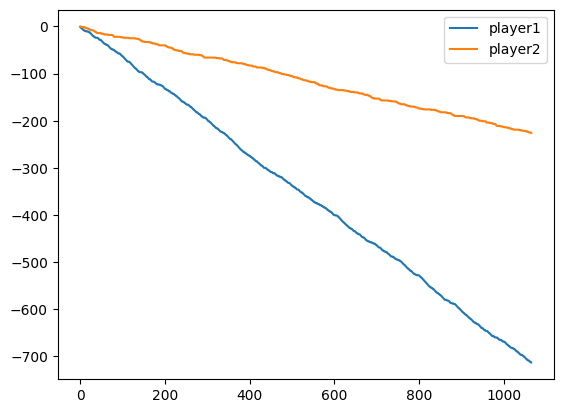

In [66]:
result = test_collector.collect(n_step=64*100)
arr = result["rews"]
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [67]:
obs = []

for days_left in range(1, 3):
    for player1_life_points in range(4):
        for player2_life_points in range(4):
            obs.append({
                'agent_id': 'player1',
                'obs': np.array([[days_left, player1_life_points, player2_life_points, 0]], dtype='float32'),
                'mask': [True, True, False]
            })

obs = tuple(obs)

acts = policy.policies[agents[1]](Batch(obs=obs, info={})).act
acts.reshape((2, 4, 4))

array([[[1, 1, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 1, 1, 1],
        [1, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]])